# Overfit and underfit

검증 데이터에 대한 모델의 정확도는 여러 반복 학습 후에 최고조에 달했다가 정체되거나 감소하기 시작한다. 즉, 모델이 학습 데이터에 과적합된다. 따라서 과적합에 대처하는 방법을 배우는 것은 중요하다. 학습 데이터에 대해서는 높은 정확도를 자주 달성하지만, 실제로 원하는 것은 테스트 세트 또는 이전에 본 적없는 새로운 데이터로 잘 일반화 할 수 있는 모델을 개발하는 것이다.

과적합의 반대는 과소적합이다. 과소적합은 학습 데이터에 대해 여전히 개선의 여지가 있을 때 발생한다. 이는 몇가지 이유로 발생할 수 있는데,
- 모델이 충분히 강력하지 않거나,
- 과도하게 정규화되었거나,
- 단순히 충분히 학습되지 않는 경우이다.

이는 네트워크가 학습 데이터에서 관련 패턴을 학습하지 않았음을 의미한다.

너무 오래 학습하면 모델이 과적합되기 시작하고 새로운 데이터에는 일반화되지 않는 학습 데이터에 대해서만 패턴을 학습한다. 따라서 균형을 잡아야 한다. **적절한 수의 Epochs에 대해 학습하는 방법**을 이해하는 것은 유용한 기술이다.

과적합을 방지하기 위한 최상의 솔루션은 더 완전한 학습 데이터를 사용하는 것이다. **데이터 세트는 모델이 처리할 것으로 예상되는 모든 입력 범위를 포함해야 한다.** 추가 데이터는 새롭고 흥미로운 사례를 다루는 경우에만 유용할 수 있다.

더 완전한 데이터로 훈련된 모델은 더 자연스럽게 잘 일반화된다. 이것이 더 이상 불가능할 때 **정규화와 같은 기술을 사용하는 것이다. 이는 모델이 저장할 수 있는 정보의 양과 유형에 제약을 걸어, 네트워크가 적은 수의 패턴만 기억할 수 있는 경우, 최적화 프로세스는 일반화 가능성이 더 높은 가장 두드러진 패턴에 집중하도록 한다.**

In [1]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy

import pathlib
import shutil
import tempfile

devices = tf.config.list_physical_devices('GPU')
print(devices)
try:
    tf.config.experimental.set_memory_growth(devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


- `tempfile.mkdtemp`: 임시 디렉토리를 생성한다. 이 디렉토리는 프로그램 종료 시에도 삭제되지 않는다. 삭제하기 위해서는 명시적으로 삭제해야 한다.
- `pathlib`: 파일시스템 경로를 단순한 문자열이 아니라 객체로 다룬다. 객체로 다루면서 연산자를 새롭게 정의할 수 있게 되었다. 슬래시(/)를 경로 구분 문자로 사용하여 직관적으로 이해할 수 있다.

In [13]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
print(logdir)
shutil.rmtree(logdir, ignore_errors=True)

C:\Users\prier\AppData\Local\Temp\tmpfkr4pi8z\tensorboard_logs


## The Higgs dataset

- 이진 분류 데이터 세트
- 학습 데이터 세트에는 10500000개의 개체가 포함되어 있다.
- 각 개체는 29개의 열로 설명된다.
    - 첫 번째 열에는 label 값이 포함되고,
    - 나머지 열들은 수치 특성이 포함된다.

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 208s 0us/step


In [5]:
FEATURES = 28

- `tf.data.experimental.CsvDataset` 클래스는 중간 압축 해제 단계 없이 gzip 파일에서 직접 csv 레코드를 읽는 데 사용할 수 있다.

In [6]:
ds = tf.data.experimental.CsvDataset(gz, [float(), ] * (FEATURES+1), compression_type="GZIP")

- 해당 csv reader 클래스는 각 레코드에 대한 스칼라 리스트를 반환한다.

In [8]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

Tensorflow는 대규모 데이터 배치에서 작업할 때 가장 효율적이다. 따라서,
1. 각 행을 개별적으로 다시 묶는 대신 10,000개 데이터의 일괄 처리를 사용하는 새로운 `tf.data.Dataset`을 만들고,
2. 각 배치에 'pack_row' 함수를 적용한 다음,
3. 배치를 개별 레코드로 다시 분할한다.

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

'packed_ds'의 일부 레코드를 검사해보자.

특성들이 완벽하게 정규화되지는 않았지만 여기서는 이것으로 충분하다.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


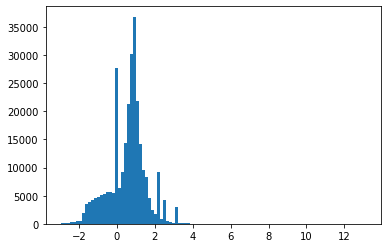

In [10]:
for features, label in packed_ds.batch(10000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

처음 1,000개 샘플은 검증에 사용, 다음 10,000개는 학습에 사용

In [14]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN / BATCH_SIZE

`Dataset.skip` 및 `Dataset.take` 메서드를 사용하면 이를 쉽게 수행할 수 있다.

동시에 `Dataset.cache` 메서드를 사용하여 loader가 각 epoch에서 파일에서 데이터를 다시 읽을 필요가 없도록 한다.

In [15]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [16]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

'train_ds'는 데이터 1개를 반환한다. `Dataset.batch` 메서드를 사용하여 학습에 적합한 크기의 batch를 생성한다.

batch를 생성하기 전에 학습 데이터에 `Dataset.shuffle`과 `Dataset.repeat`을 적용하는 것도 잊지 말아야 한다.

In [17]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)